In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
raw_data = pd.read_csv("1996 to 2023 CombinedData.csv")

In [4]:
raw_data.columns

Index(['Unnamed: 0', 'name', 'datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions',
       'description', 'icon', 'stations'],
      dtype='object')

# Check Monthly Seasonality

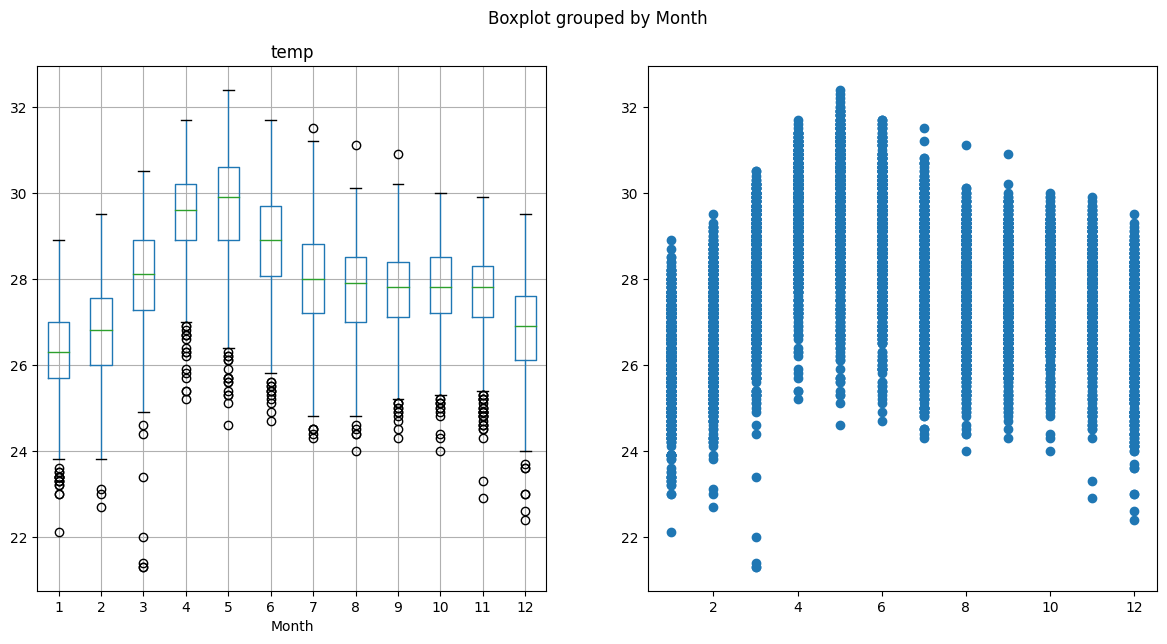

In [11]:
df = raw_data.copy()
df["Month"] = pd.DatetimeIndex(df["datetime"]).month
df["Year"] = pd.DatetimeIndex(df["datetime"]).year

fig, ax = plt.subplots(1, 2, figsize = (14, 7))
df.boxplot(column = ["temp"], by = "Month", ax = ax[0])
plt.scatter(df["Month"], df["temp"])
plt.show()


# Check Yearly Seasonality

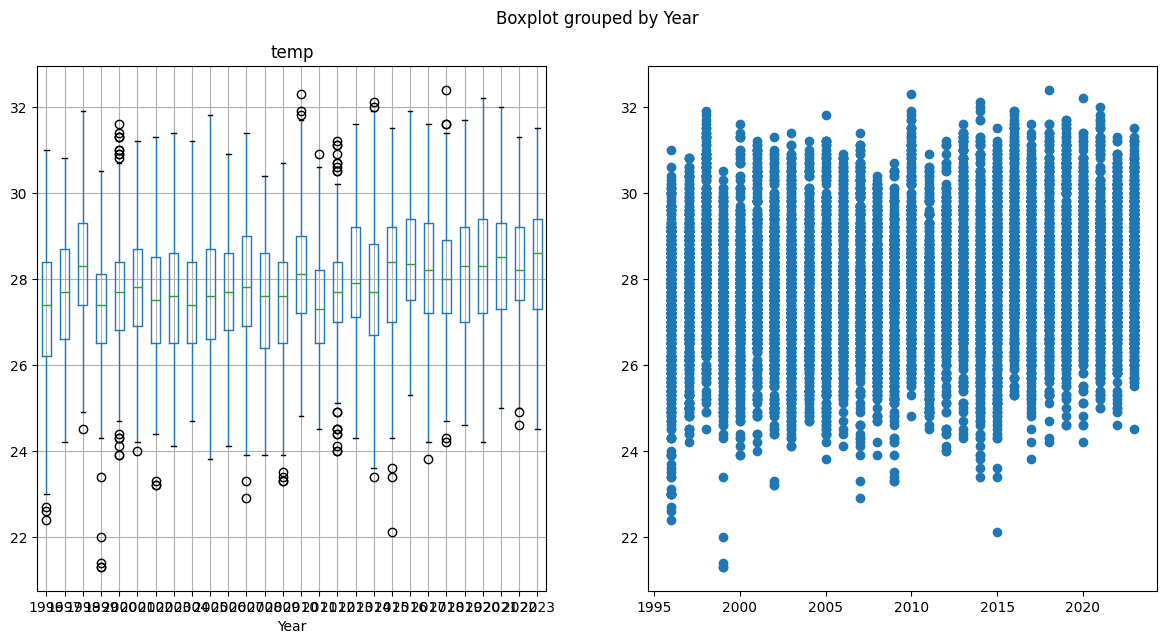

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
df.boxplot(column = ["temp"], by = "Year", ax = ax[0])
plt.scatter(df["Year"], df["temp"])
plt.show()


# Remove Monthly Mean

Since there is no seasonality found on the yearly data, but strong seasonality observed in 